Model parameters: 0.218324 M
Step 0: Train loss 4.6690, Val loss 4.6694, Perplexity 106.6376
Step 100: Train loss 2.7268, Val loss 2.7203, Perplexity 15.1854
Step 200: Train loss 2.6026, Val loss 2.6010, Perplexity 13.4775
Step 300: Train loss 2.5675, Val loss 2.5653, Perplexity 13.0048
Step 400: Train loss 2.5481, Val loss 2.5479, Perplexity 12.7805
Step 500: Train loss 2.5259, Val loss 2.5268, Perplexity 12.5134
Step 600: Train loss 2.5040, Val loss 2.5062, Perplexity 12.2581
Step 700: Train loss 2.4864, Val loss 2.4924, Perplexity 12.0902
Step 800: Train loss 2.4466, Val loss 2.4516, Perplexity 11.6067
Step 900: Train loss 2.4158, Val loss 2.4217, Perplexity 11.2647
Step 1000: Train loss 2.3755, Val loss 2.3882, Perplexity 10.8940
Step 1100: Train loss 2.3499, Val loss 2.3632, Perplexity 10.6250
Step 1200: Train loss 2.3228, Val loss 2.3435, Perplexity 10.4178
Step 1300: Train loss 2.2936, Val loss 2.3105, Perplexity 10.0795
Step 1400: Train loss 2.2796, Val loss 2.2965, Perplexity 

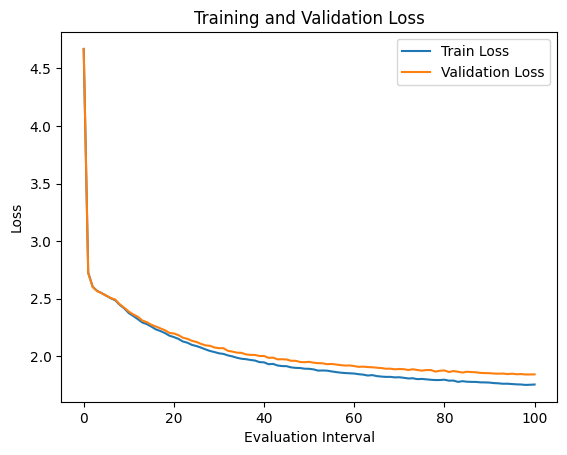

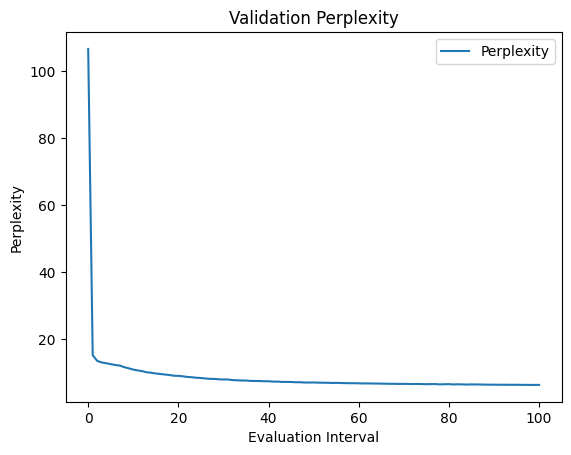

In [14]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define a dictionary to hold the parameters
parametry = {
    "batch_size": 32,
    "block_size": 64,
    "max_iters": 10000,
    "eval_interval": 100,
    "learning_rate": 1e-3,
    "n_embd": 64,
    "n_head": 4,
    "n_layer": 4,
    "dropout": 0.1,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "eval_iters": 200,
}


torch.manual_seed(166045)

# Adjust block_size dynamically based on available GPU memory
if parametry["device"] == "cuda":
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    parametry["block_size"] = min(128, max(16, gpu_memory // (parametry["n_embd"] * 1024)))

# Function to calculate perplexity
def perplexity(loss):
    return torch.exp(loss)

# Function to initialize hyperparameters from a dictionary
def initialize_params(params):
    globals().update(params)

# Initialize hyperparameters
initialize_params(parametry)

# Prepare the dataset
with open('pan-tadeusz.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split, seq_sampling=False):
    data = train_data if split == 'train' else val_data
    if seq_sampling:
        start_idx = torch.randint(0, len(data) - block_size, (1,)).item()
        x = data[start_idx:start_idx + block_size].unsqueeze(0).repeat(batch_size, 1)
        y = data[start_idx + 1:start_idx + block_size + 1].unsqueeze(0).repeat(batch_size, 1)
    else:
        ix = torch.randint(len(data) - block_size, (batch_size,))
        x = torch.stack([data[i:i + block_size] for i in ix])
        y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x + self.dropout(self.sa(self.ln1(x)))
        x = x + self.dropout(self.ffwd(self.ln2(x)))
        return x

class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)



    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Initialize and train the model
model = GPTModel().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6} M")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses, val_losses, perplexities = [], [], []

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        perplexities.append(perplexity(losses['val']).item())
        print(f"Step {iter}: Train loss {losses['train']:.4f}, Val loss {losses['val']:.4f}, Perplexity {perplexities[-1]:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Training loss plot
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Evaluation Interval')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Perplexity plot
plt.figure()
plt.plot(perplexities, label='Perplexity')
plt.legend()
plt.xlabel('Evaluation Interval')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')
plt.show()

# Generate text
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(model.generate(context, max_new_tokens=2000)[0].tolist())

with open('generated_text.txt', 'w', encoding='utf-8') as f:
    f.write(generated_text)
